In [3]:
!pip install qonnx
!pip install netron


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import brevitas.nn as qnn
# from brevitas.quant import SignedBinaryWei|ghtPerTensorConst, Int8WeightPerTensorFixedPoint
from brevitas.nn import QuantIdentity
# from brevitas.export import export_qonnx
from copy import deepcopy
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
data_dir = ""
df_normal = pd.DataFrame(np.load(data_dir + "normal_data.npy", allow_pickle=True))
df_normal[320] = 1

df_leak = pd.DataFrame(np.load(data_dir + "leak_data.npy", allow_pickle=True))
df_leak[320] = 0

data = pd.concat([df_normal, df_leak])
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
np.savez('test_data.npz',testX=X_test, testY=y_test)
print("success")

success


In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# tensor 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

# weight_quant = SignedBinaryWeightPerTensorConst # 평균0.4loss, accuracy=0.8
weight_quant = Int8WeightPerTensorFixedPoint

NameError: name 'Int8WeightPerTensorFixedPoint' is not defined

In [17]:
# class Model(nn.Module): # 옛날 모델
#     def __init__(self):
#         super().__init__()
#         self.layer1 = qnn.QuantLinear(320, 128, bias=True, weight_quant=weight_quant)
#         self.batch_norm1 = nn.BatchNorm1d(128)

#         self.layer2 = qnn.QuantLinear(128, 128, bias=True, weight_quant=weight_quant)
#         self.batch_norm2 = nn.BatchNorm1d(128)

#         self.layer3 = qnn.QuantLinear(128, 64, bias=True, weight_quant=weight_quant)
#         self.batch_norm3 = nn.BatchNorm1d(64)

#         self.output = qnn.QuantLinear(64, 1, bias=True, weight_quant=weight_quant)
#         self.relu = qnn.QuantReLU(weight_quant=weight_quant)
#         # self.sigmoid = qnn.QuantSigmoid(weight_quant=weight_quant)

#     def forward(self, x):
#         x = self.relu(self.layer1(x))
#         x = self.batch_norm1(x)

#         x = self.relu(self.layer2(x))
#         x = self.batch_norm2(x)

#         x = self.relu(self.layer3(x))
#         x = self.batch_norm3(x)

#         x = self.output(x)
#         return x

# 양자화 모델
model = nn.Sequential(
    qnn.QuantLinear(320, 128, bias=True, weight_bit_width=8), # input 20, +1
    nn.BatchNorm1d(128),
    qnn.QuantReLU(bit_width=8),
    
    # qnn.QuantLinear(128, 128, bias=True, weight_bit_width=8),
    # nn.BatchNorm1d(128),
    # qnn.QuantReLU(bit_width=8),

    qnn.QuantLinear(128, 64, bias=True, weight_bit_width=8),
    nn.BatchNorm1d(64),
    qnn.QuantReLU(bit_width=8),
    
    qnn.QuantLinear(64, 1, bias=True, weight_bit_width=8),
)
# 일반 모델
normal_model = nn.Sequential(
    nn.Linear(320, 128, bias=True),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Linear(128, 128, bias=True),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Linear(128, 64, bias=True),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Linear(64, 1, bias=True),
)

# quantized_model_size_file_name = "quantized_model_size.pth"
# normal_model_size_file_name = "normal_model_size.pth"

# torch.save(model.state_dict(), quantized_model_size_file_name)
# torch.save(normal_model.state_dict(), normal_model_size_file_name)

# size_quantized = os.path.getsize(quantized_model_size_file_name)
# size_normal = os.path.getsize(normal_model_size_file_name)

# print("Quantized model size:", size_quantized, "bytes")
# print("Normal model size:", size_normal, "bytes")

# os.remove(quantized_model_size_file_name)
# os.remove(normal_model_size_file_name)

# 사이즈가 양자화 적용한 것이 더 큼.
# 이유는 Fake Qunt라서 ~를 양자화 한다는 정보만 있을 뿐 아직까지 실제로 양자화된 것은 아님

model.to(device)


Sequential(
  (0): QuantLinear(
    in_features=320, out_features=128, bias=True
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): _StatsScaling(


In [18]:
# # normal model onnx export
# normal_model.eval()

# dummy_input = torch.randn(1, 320)

# torch.onnx.export(
#     normal_model,                 # 모델
#     dummy_input,                  # 예시 입력
#     "normal_model.onnx",          # 저장할 파일명
#     input_names=['input'],        # 입력 이름
#     output_names=['output'],      # 출력 이름
#     opset_version=11              # ONNX opset (11~17 사용 가능)
# )
# torch.onnx.export(
#     model,
#     dummy_input,
#     "quant_onnx.onnx",
#     input_names=['input'],        # 입력 이름
#     output_names=['output'],      # 출력 이름
#     opset_version=11      
# )
# print("export complete")

In [19]:
# model = Model()


criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001 , betas=(0.9, 0.999))

epochs = 40
loss_history = []
acc_history = []


In [20]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

model.train()

for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    predictions = (outputs > 0.5).float()
    accuracy = (predictions == y_train_tensor).float().mean().item()

    loss_history.append(loss.item())
    acc_history.append(accuracy)
    if epoch % 20 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Accuracy: {accuracy:.4f}")

# 양자화 하지 않은 모델 Loss: 0.0810 ~ 0.0910 Accuracy: 0.9805 ~ 0.9905

# epoch 40 = Loss: 0.0859, Accuracy: 0,=.9913
# epoch가 40을 넘어가면 Accuracy가 떨어지는 양상을 보임
        #예) epoch 40/50 Loss 0.0815, Accuracy: 0.09916
        # epoch 50/50 Loss 0.0636, Accuracy: 0.09912



/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


Epoch 1/40 - Loss: 0.7616 - Accuracy: 0.4041
Epoch 21/40 - Loss: 0.1541 - Accuracy: 0.9702
Epoch 40/40 - Loss: 0.0817 - Accuracy: 0.9900


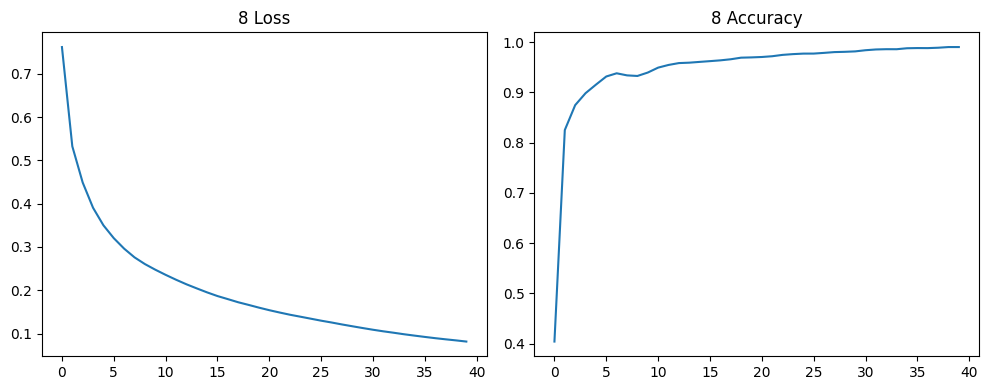

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("8 Loss")

plt.subplot(1, 2, 2)
plt.plot(acc_history)
plt.title("8 Accuracy")
plt.tight_layout()
plt.show()


# 모델 내보내기

In [22]:
from copy import deepcopy
model = model.cpu()
# 모델 복사
modified_model = deepcopy(model)

from brevitas.nn import QuantIdentity


class CybSecMLPForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(CybSecMLPForExport, self).__init__()
        self.pretrained = my_pretrained_model
        # 모델
        self.qnt_output = QuantIdentity(
            quant_type='binary',
            scaling_impl_type='const',
            bit_width=1, min_val=-1.0, max_val=1.0)

    def forward(self, x):
        x = (x + torch.tensor([1.0]).to(x.device)) / 2.0
        print(x.shape)
        out_original = self.pretrained(x)
        out_final = self.qnt_output(out_original)   # output as {-1,1}
        return out_final

model_for_export = CybSecMLPForExport(modified_model)
model_for_export.to(device)

CybSecMLPForExport(
  (pretrained): Sequential(
    (0): QuantLinear(
      in_features=320, out_features=128, bias=True
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (output_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (weight_quant): WeightQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClampSte()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): StatsFromParameterScaling(
            (parameter_list_stats): _ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper(
                (view_shape_impl): OverTensorView()
              )
              (stats): _Stats(
                (stats_imp

In [23]:
import sys
sys.path.append('/home/cloud9/finn_dlp/notebook/end2end_example/cybersecurity/')

from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.core.datatype import DataType
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN

ready_model_filename = "plz_work.onnx"
input_shape = (1, 320)

input_a = np.random.randint(0, 1, size=input_shape).astype(np.float32)
input_a = 2 * input_a - 1
scale = 1.0
input_t = torch.from_numpy(input_a * scale)
print (input_t.shape)
model_for_export.cpu()
export_qonnx(model_for_export, export_path=ready_model_filename, input_t=input_t)

# Perform cleanup
qonnx_cleanup(ready_model_filename, out_file=ready_model_filename)


torch.Size([1, 320])
torch.Size([1, 320])
torch.Size([1, 320])


In [24]:
# Wrap the model with ModelWrapper
model = ModelWrapper(ready_model_filename)

# Explicitly set the input data type to BIPOLAR
model.set_tensor_datatype(model.graph.input[0].name, DataType["FLOAT32"])

# Convert QONNX to FINN
model = model.transform(ConvertQONNXtoFINN())

# Save the transformed model
model.save(ready_model_filename)
print("됐나?")

/home/cloud9/finn/deps/qonnx/src/qonnx/transformation/gemm_to_matmul.py:57: UserWarning: The GemmToMatMul transformation only offers explicit support for version 9 of the Gemm node, but the ONNX version of the supplied model is 14. Thus the transformation may fail or return incomplete results.
  warnings.warn(


됐나?


In [25]:
import onnx

def show_model_info(path):
    model = onnx.load(path)
    print(f"Model: {path}")
    print(f"Total Nodes: {len(model.graph.node)}")
    print("First 10 Nodes:")
    for node in model.graph.node[:10]:
        print(f"- {node.op_type}")
    print("\n")

show_model_info("normal_model.onnx")
show_model_info("plz_work.onnx")

FileNotFoundError: [Errno 2] No such file or directory: 'normal_model.onnx'

In [26]:
import onnxruntime as ort
import numpy as np
import time

def measure_inference_time(model_path, repeat=1000):
    session = ort.InferenceSession(model_path)

    input_name = session.get_inputs()[0].name
    input_shape = session.get_inputs()[0].shape
    input_dtype = np.float32

    dummy_input = np.random.randn(*[1 if x is None else x for x in input_shape]).astype(input_dtype)

    _ = session.run(None, {input_name: dummy_input})

    start = time.time()
    for _ in range(repeat):
        _ = session.run(None, {input_name: dummy_input})
    end = time.time()

    avg_time = (end - start) / repeat * 1000  # ms
    print(f"{model_path} → 평균 추론 시간: {avg_time:.4f} ms ({repeat}회 평균)")
    return avg_time

# 실행
t1 = measure_inference_time("normal_model.onnx", repeat=10000)
t2 = measure_inference_time("quant_onnx.onnx", repeat=10000)


NoSuchFile: [ONNXRuntimeError] : 3 : NO_SUCHFILE : Load model from normal_model.onnx failed:Load model normal_model.onnx failed. File doesn't exist

In [ ]:
# 모델을 onnx로 export만 했을 때는 용량도 더 크고, 성능도 더 느림
# 